In [1]:
import numpy as np
import pandas as pd
from math import floor, ceil
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import norm
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
np.random.seed(1005)

# Q3 (a)(i)

In [2]:
def load(file_path):
    return pd.read_csv(file_path)

df_train = load("hw1_q3_train_data.csv")
df_test = load("hw1_q3_test_data.csv")

print("First few rows of training data:")
print(df_train.head())

# Data Preprocessing 
def preprocess(df):
    X = df.iloc[:, :-1].values 
    y = df.iloc[:, -1].values
    return X, y

X_train, y_train = preprocess(df_train)
X_test, y_test = preprocess(df_test)

print("\nShapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Normalizing the data
def normalize(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_normalized = (X_train - mean) / std
    X_test_normalized = (X_test - mean) / std
    return X_train_normalized, X_test_normalized

X_train_normalized, X_test_normalized = normalize(X_train, X_test)


print("\nShapes after normalization:")
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

First few rows of training data:
   cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0           609          6                6          10     0.083984   
1           833          6                0          10     0.453179   
2           322          6                5           5     0.469946   
3           204          6                5           5     0.477904   
4           919          5                1           7     0.783435   

   stem-width  stem-color    season  class  
0        1388          11  0.888450      0  
1        1370          11  0.888450      0  
2         584           6  0.888450      1  
3         632          11  0.943195      1  
4        1339           8  0.888450      1  

Shapes:
X_train: (432, 8)
y_train: (432,)
X_test: (324, 8)
y_test: (324,)

Shapes after normalization:
X_train_normalized: (432, 8)
X_test_normalized: (324, 8)


# Q3 (a)(ii)

In [3]:
class_proportions = df_train['class'].value_counts(normalize=True)
print(class_proportions)

class
1    0.548611
0    0.451389
Name: proportion, dtype: float64


Because the proportion of samples in total is 0.549 and 0.451, meaning the dataset is balanced. Therefore, accuracy is a more appropriate performance metric to use for this task.

# Q3 (b)(i)

In [4]:
def creat_five_fold(X, y):
    X, y = np.array(X), np.array(y)
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_size = n_samples // 5

    folds = []
    for i in range(5):
        start, end = i * fold_size, (i + 1) * fold_size if i < 4 else n_samples
        test_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])
        folds.append((train_indices, test_indices))
    
    return folds

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    return true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

def recall(y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    return true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

def f1_score(y_true, y_pred):
    p, r = precision(y_true, y_pred), recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

# kNN algorithm
class KNN:
    def __init__(self, k):
        self.k = k
    
    def train(self, X, y):
        self.X_train, self.y_train = X, y

    def predict(self, X):
        return np.array([self._predict(x) for x in X])
    
    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return np.bincount(k_nearest_labels).argmax()
    
    def _get_neighbor_votes(self, X):
        neighbor_votes = []
        for x in X:
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            neighbor_votes.append(np.sum(k_nearest_labels))
        return np.array(neighbor_votes)
    
    def roc_curve(self, X, y):
        neighbor_votes = self._get_neighbor_votes(X)
        groups = [[] for _ in range(self.k + 1)]
        for i, (votes, label) in enumerate(zip(neighbor_votes, y)):
            groups[votes].append((i, label))
        
        total_positives = np.sum(y)
        total_negatives = len(y) - total_positives
        
        tpr, fpr = [], []
        tp = fp = 0

        for i in range(self.k, -1, -1):
            for _, label in groups[i]:
                if label == 1:
                    tp += 1
                else:
                    fp += 1
            
            tpr.append(tp / total_positives if total_positives > 0 else 0)
            fpr.append(fp / total_negatives if total_negatives > 0 else 0)
        
        return np.array(fpr), np.array(tpr)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return {
            'accuracy': accuracy(y, y_pred),
            'precision': precision(y, y_pred),
            'recall': recall(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }

In [5]:
n_samples = X_train_normalized.shape[0]
k = int(np.sqrt(n_samples))
if k % 2 == 0:
    k += 1

print(f"Chosen value of k: {k}")

Chosen value of k: 21


In [6]:
# Results on the test set
knn = KNN(k)
knn.train(X_train_normalized, y_train)  

metrics = knn.evaluate(X_test_normalized, y_test)
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1 Score: {metrics['f1_score']:.2f}")

Accuracy: 0.63
Precision: 0.69
Recall: 0.60
F1 Score: 0.64


# Q3 (b)(ii)

In [7]:
class KNN_threshold:
    def __init__(self, k, threshold=0.4):
        self.k = k
        self.threshold = threshold

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return np.array([self._predict(x) for x in X])
    
    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return 1 if np.mean(k_nearest_labels) >= self.threshold else 0
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return {
            'accuracy': accuracy(y, y_pred),
            'precision': precision(y, y_pred),
            'recall': recall(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }

In [8]:
threshold = 0.4

knn = KNN_threshold(k, threshold)
knn.train(X_train_normalized, y_train)
metrics = knn.evaluate(X_test_normalized, y_test)
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1 Score: {metrics['f1_score']:.2f}")

Accuracy: 0.61
Precision: 0.62
Recall: 0.78
F1 Score: 0.69


After threshold adjustment (0.4): Precision decreased, Recall increased, and F1 Score rose to 0.7. This means that the model is more sensitive in detecting poisonous mushrooms but generates more false positives. Accuracy decreased slightly to 0.61, indicating a slightly lower overall correct classification rate.

# Q3 (c)(i)

In [10]:
class KNN_5_folds:
    def __init__(self, k, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        return np.array([self._predict(x) for x in X])
    
    def _predict(self, x):
        if self.distance_metric == 'euclidean':
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == 'manhattan':
            distances = [manhattan_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == 'cosine':
            distances = [cosine_similarity(x, x_train) for x_train in self.X_train]
        else:
            raise ValueError(f"Unknown distance metric: {self.distance_metric}")
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return np.bincount(k_nearest_labels).argmax()
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return {
            'accuracy': accuracy(y, y_pred),
            'precision': precision(y, y_pred),
            'recall': recall(y, y_pred),
            'f1_score': f1_score(y, y_pred)
        }

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def cosine_similarity(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

Average F1 Score for Fold 1 with Euclidean distance: 0.70
Average F1 Score for Fold 2 with Euclidean distance: 0.67
Average F1 Score for Fold 3 with Euclidean distance: 0.64
Average F1 Score for Fold 4 with Euclidean distance: 0.64
Average F1 Score for Fold 5 with Euclidean distance: 0.69


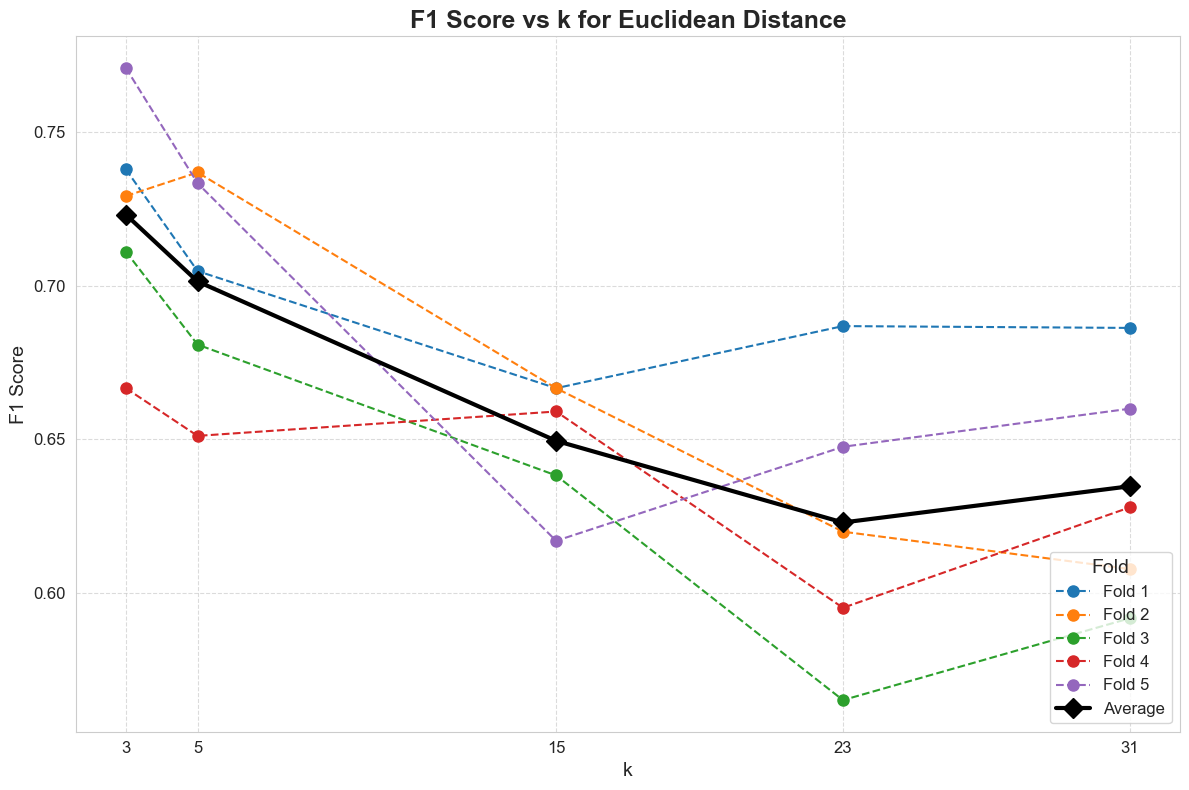

Best combination: k=3, distance metric=euclidean
F1 Score: 0.77


In [14]:
ks = [3, 5, 15, 23, 31]
best_combination = {'f1_score': 0, 'k': 0, 'metric': ''}
kf = creat_five_fold(X_train, y_train) 

avg_f1s_euclid = [[] for _ in range(len(ks))]
total_f1s_euclid = []

for fold, (train_index, test_index) in enumerate(kf, 1):
    X_train_kf, X_val = X_train[train_index], X_train[test_index]
    y_train_kf, y_val = y_train[train_index], y_train[test_index]
    
    X_train_kf, X_val = normalize(X_train_kf, X_val)
    
    fold_f1s = []
    for k_idx, k in enumerate(ks):
        knn = KNN_5_folds(k, distance_metric='euclidean')
        knn.train(X_train_kf, y_train_kf)
        f1 = knn.evaluate(X_val, y_val)['f1_score']
        
        if f1 > best_combination['f1_score']:
            best_combination = {'f1_score': f1, 'k': k, 'metric': 'euclidean'}
        
        avg_f1s_euclid[k_idx].append(f1)
        fold_f1s.append(f1)
    
    print(f"Average F1 Score for Fold {fold} with Euclidean distance: {np.mean(fold_f1s):.2f}")
    total_f1s_euclid.append(fold_f1s)

avg_f1s_euclid = [np.mean(f1s) for f1s in avg_f1s_euclid]
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
for i, fold_f1s in enumerate(total_f1s_euclid, 1):
    plt.plot(ks, fold_f1s, label=f"Fold {i}", linestyle='--', marker='o', markersize=8)
plt.plot(ks, avg_f1s_euclid, label="Average", color='black', linewidth=3, marker='D', markersize=10)
plt.title("F1 Score vs k for Euclidean Distance", fontsize=18, fontweight='bold')
plt.xlabel("k", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(ks, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Fold", fontsize=12, title_fontsize=14, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Best combination: k={best_combination['k']}, distance metric={best_combination['metric']}")
print(f"F1 Score: {best_combination['f1_score']:.2f}")

Fold 1
Average F1 Score for Fold 1 with Manhattan distance: 0.72
Fold 2
Average F1 Score for Fold 2 with Manhattan distance: 0.69
Fold 3
Average F1 Score for Fold 3 with Manhattan distance: 0.64
Fold 4
Average F1 Score for Fold 4 with Manhattan distance: 0.68
Fold 5
Average F1 Score for Fold 5 with Manhattan distance: 0.74


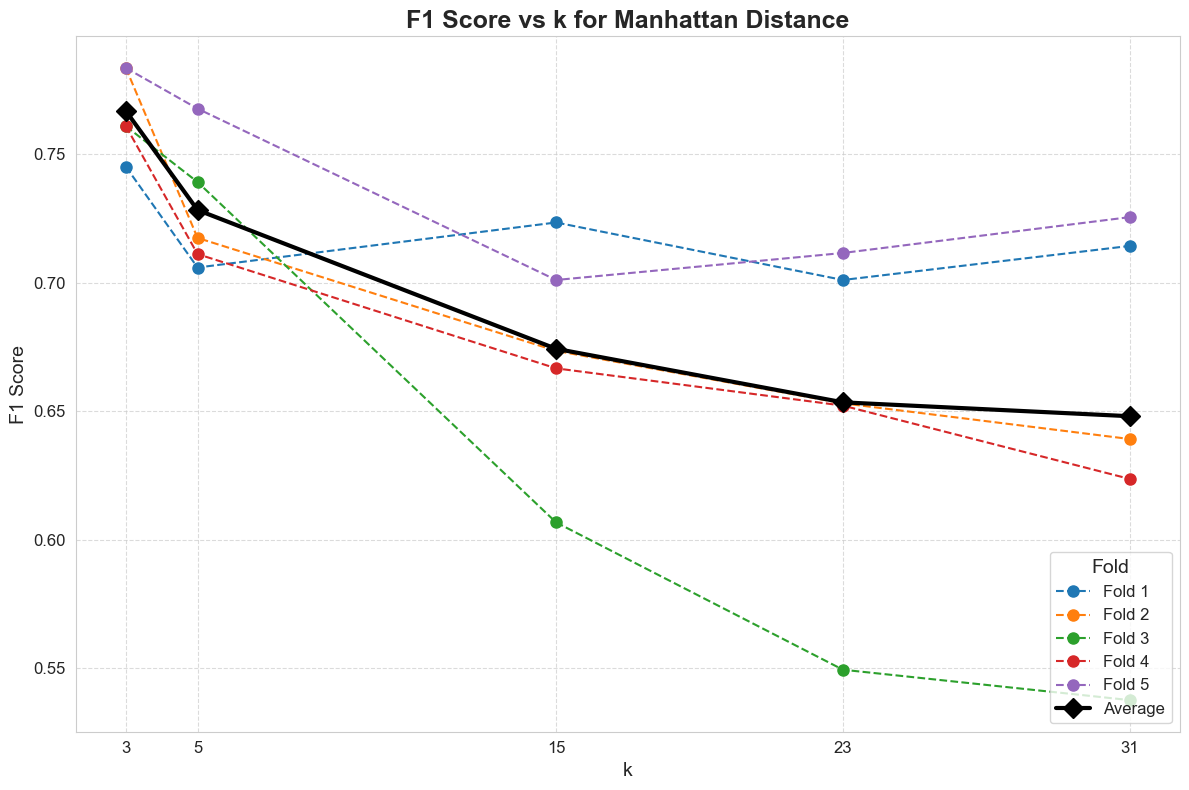

Best combination: k=3, distance metric=manhattan
F1 Score: 0.78


In [15]:
avg_f1s_manhattan = [[] for _ in range(5)]
total_f1s_manhattan = []

# Perform 5-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf, 1):
    print(f"Fold {fold}")
    X_train_kf, X_val = X_train[train_index], X_train[test_index]
    y_train_kf, y_val = y_train[train_index], y_train[test_index]
    
    X_train_kf, X_val = normalize(X_train_kf, X_val)
    
    fold_f1s = []
    for k_idx, k in enumerate(ks):
        knn = KNN_5_folds(k, distance_metric='manhattan')
        knn.train(X_train_kf, y_train_kf)
        f1 = knn.evaluate(X_val, y_val)['f1_score']
        
        if f1 > best_combination['f1_score']:
            best_combination = {'f1_score': f1, 'k': k, 'metric': 'manhattan'}
        
        avg_f1s_manhattan[k_idx].append(f1)
        fold_f1s.append(f1)
    
    print(f"Average F1 Score for Fold {fold} with Manhattan distance: {np.mean(fold_f1s):.2f}")
    total_f1s_manhattan.append(fold_f1s)


avg_f1s_manhattan = [np.mean(f1s) for f1s in avg_f1s_manhattan]

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
for i, fold_f1s in enumerate(total_f1s_manhattan, 1):
    plt.plot(ks, fold_f1s, label=f"Fold {i}", linestyle='--', marker='o', markersize=8)

plt.plot(ks, avg_f1s_manhattan, label="Average", color='black', linewidth=3, marker='D', markersize=10)
plt.title("F1 Score vs k for Manhattan Distance", fontsize=18, fontweight='bold')
plt.xlabel("k", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(ks, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title="Fold", fontsize=12, title_fontsize=14, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(f"Best combination: k={best_combination['k']}, distance metric={best_combination['metric']}")
print(f"F1 Score: {best_combination['f1_score']:.2f}")

Fold 1
Average F1 Score for Fold 1 with Cosine Similarity: 0.46
Fold 2
Average F1 Score for Fold 2 with Cosine Similarity: 0.42
Fold 3
Average F1 Score for Fold 3 with Cosine Similarity: 0.50
Fold 4
Average F1 Score for Fold 4 with Cosine Similarity: 0.56
Fold 5
Average F1 Score for Fold 5 with Cosine Similarity: 0.53


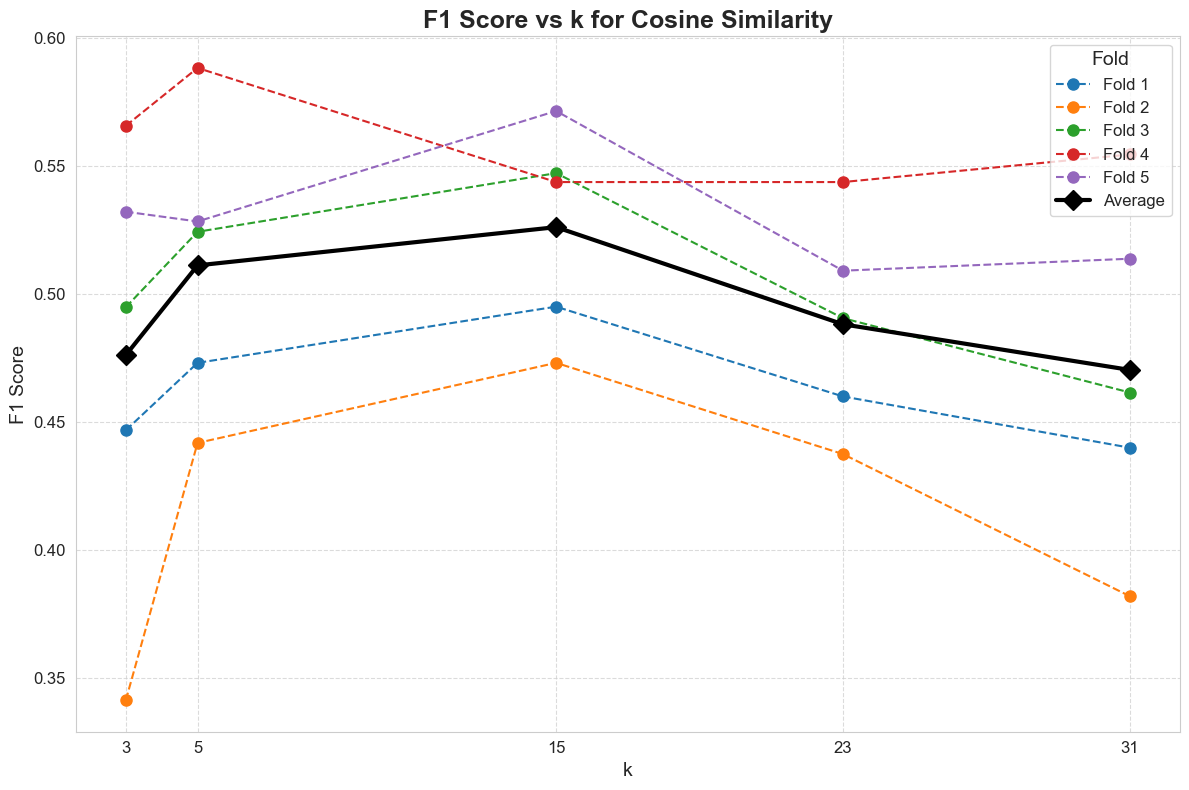

Best combination: k=3, distance metric=manhattan
F1 Score: 0.78


In [19]:
kf = creat_five_fold(X_train, y_train)  
avg_f1s_cosine = [[] for _ in range(5)]
total_f1s_cosine = []

for fold, (train_index, test_index) in enumerate(kf, 1):
    print(f"Fold {fold}")
    X_train_kf, X_val = X_train[train_index], X_train[test_index]
    y_train_kf, y_val = y_train[train_index], y_train[test_index]
    
    X_train_kf, X_val = normalize(X_train_kf, X_val)
    
    fold_f1s = []
    for k_idx, k in enumerate(ks):
        knn = KNN_5_folds(k, distance_metric='cosine')
        knn.train(X_train_kf, y_train_kf)
        f1 = knn.evaluate(X_val, y_val)['f1_score']
        
        if f1 > best_combination['f1_score']:
            best_combination = {'f1_score': f1, 'k': k, 'metric': 'cosine'}
        
        avg_f1s_cosine[k_idx].append(f1)
        fold_f1s.append(f1)
    
    print(f"Average F1 Score for Fold {fold} with Cosine Similarity: {np.mean(fold_f1s):.2f}")
    total_f1s_cosine.append(fold_f1s)

avg_f1s_cosine = [np.mean(f1s) for f1s in avg_f1s_cosine]

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

for i, fold_f1s in enumerate(total_f1s_cosine, 1):
    plt.plot(ks, fold_f1s, label=f"Fold {i}", linestyle='--', marker='o', markersize=8)

plt.plot(ks, avg_f1s_cosine, label="Average", color='black', linewidth=3, marker='D', markersize=10)

plt.title("F1 Score vs k for Cosine Similarity", fontsize=18, fontweight='bold')
plt.xlabel("k", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(ks, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title="Fold", fontsize=12, title_fontsize=14, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Best combination: k={best_combination['k']}, distance metric={best_combination['metric']}")
print(f"F1 Score: {best_combination['f1_score']:.2f}")

In [13]:
# Report the best combination and show the F1 score
print(f"Best combination: k={best_combination['k']}, distance metric={best_combination['metric']}")
print(f"F1 Score: {best_combination['f1_score']:.2f}")

Best combination: k=3, distance metric=manhattan
F1 Score: 0.84


# Q3 (c)(ii)

In [20]:
# Test the best combination
knn = KNN_5_folds(best_combination['k'], distance_metric=best_combination['metric'])
knn.train(X_train_normalized, y_train)

# Evaluate the model
metrics = knn.evaluate(X_test_normalized, y_test)

# Print the results
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1 Score: {metrics['f1_score']:.2f}")

Accuracy: 0.85
Precision: 0.88
Recall: 0.86
F1 Score: 0.87


The model with the best parameters performs better than the previous model

# Q3 (d)(i)

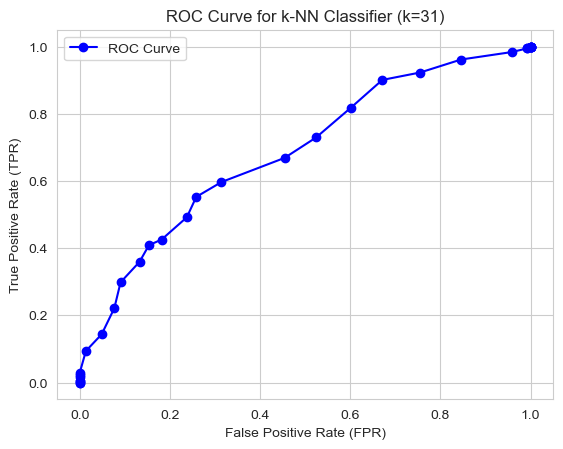

In [21]:
#(d)(i)
# k-NN prediction with dynamic k value
def knn_predict(X_train, y_train, X_test, k):
    def euclidean_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    kpos = []
    for x in X_test:
        distances = np.array([euclidean_distance(x, x_train) for x_train in X_train])
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        kpos.append(np.sum(k_nearest_labels == 1))  
    
    return np.array(kpos)

kpos = knn_predict(X_train, y_train, X_test, k)

thresholds = np.arange(k+1) 
tpr_list = []
fpr_list = []

for threshold in thresholds:
    y_pred = (kpos > threshold).astype(int)

    TP = np.sum((y_pred == 1) & (y_test == 1))
    FP = np.sum((y_pred == 1) & (y_test == 0))
    TN = np.sum((y_pred == 0) & (y_test == 0))
    FN = np.sum((y_pred == 0) & (y_test == 1))
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    tpr_list.append(TPR)
    fpr_list.append(FPR)

    fpr_array = np.array(fpr_list)
    tpr_array = np.array(tpr_list)

    sorted_indices = np.argsort(fpr_array)
    fpr_sorted = fpr_array[sorted_indices]
    tpr_sorted = tpr_array[sorted_indices]
    
# Plot ROC
plt.plot(fpr_list, tpr_list, marker='o', linestyle='-', color='b', label="ROC Curve")
plt.title(f'ROC Curve for k-NN Classifier (k={k})')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(True)
plt.legend()
plt.show()

# Q3 (d)(ii)


In [22]:
#(d)(ii)
def calculate_auc(fpr, tpr):
    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    return auc

# Compute AUC
auc = calculate_auc(fpr_sorted, tpr_sorted)
print(f"AUC: {auc}")


AUC: 0.6852180968203067


# Q4 (a)

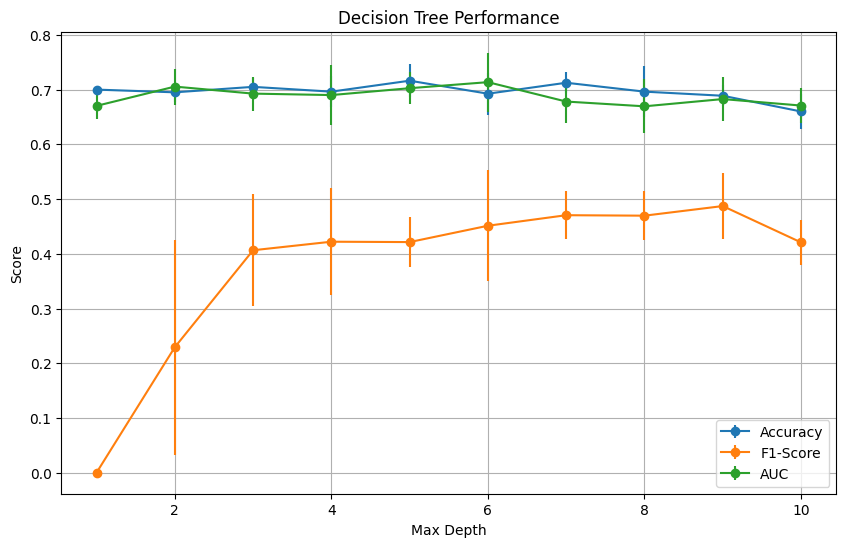

best depth is : 9


In [5]:
#(a)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
import matplotlib.pyplot as plt
from gosdt import GOSDT
from gosdt.model import threshold_guess
from gosdt.model.threshold_guess import compute_thresholds
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import plot_tree

data = pd.read_csv('german_credit.csv')
X = data.drop(columns='target')
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

cv = StratifiedKFold(n_splits=5, shuffle=True)

depth_range = range(1, 11)
mean_accuracies = []
mean_f1 = []
mean_auc = []
std_accuracies = []
std_f1 = []
std_auc = []

for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth)
    
    acc =cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    f1 = cross_val_score(clf, X_train, y_train, cv=cv, scoring=make_scorer(f1_score))
    auc = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
    
    mean_accuracies.append(np.mean(acc))
    mean_f1.append(np.mean(f1))
    mean_auc.append(np.mean(auc))
    
    std_accuracies.append(np.std(acc))
    std_f1.append(np.std(f1))
    std_auc.append(np.std(auc))

plt.figure(figsize=(10, 6))

plt.errorbar(depth_range, mean_accuracies, yerr=std_accuracies, label='Accuracy', fmt='-o')
plt.errorbar(depth_range, mean_f1, yerr=std_f1, label='F1-Score', fmt='-o')
plt.errorbar(depth_range, mean_auc, yerr=std_auc, label='AUC', fmt='-o')

plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Decision Tree Performance')
plt.legend()
plt.grid(True)
plt.show()

best_depth = depth_range[np.argmax(mean_f1)]  
print(f"best depth is : {best_depth}")

# Q4 (b)

best parameter: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
F1-score: 0.3541666666666667
Accuracy: 0.69
AUC: 0.7233333333333334


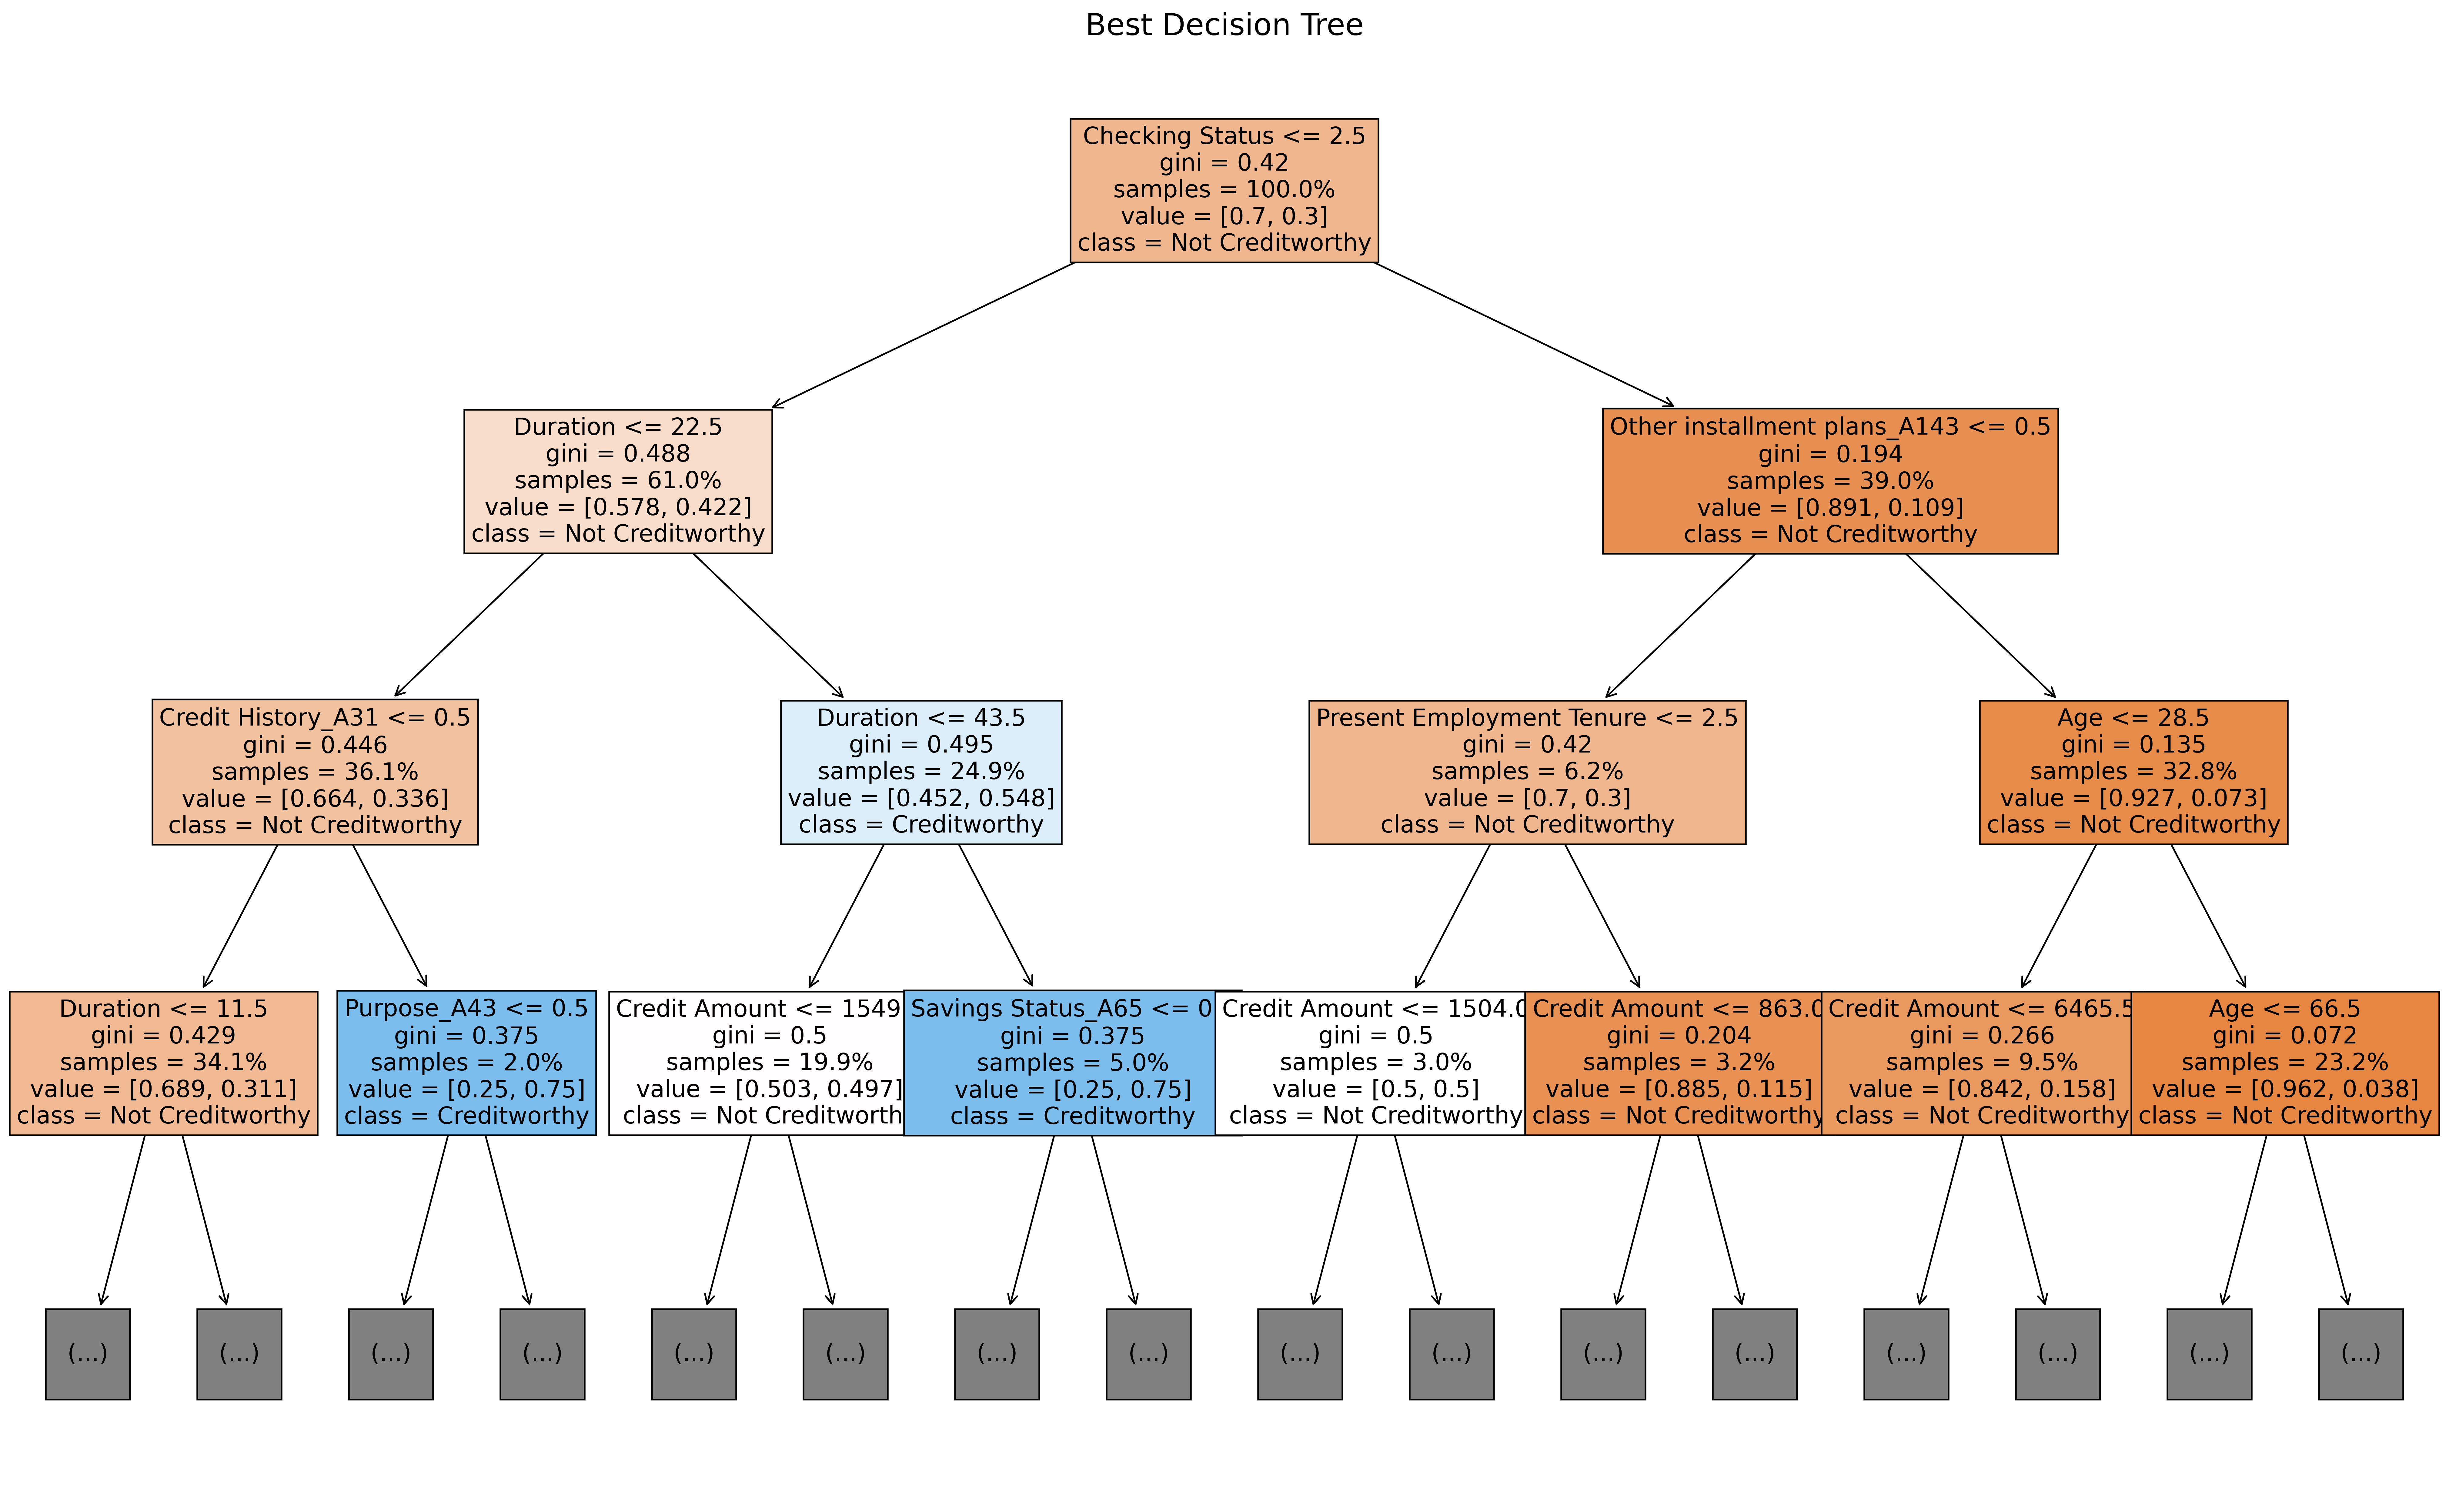

In [6]:

param_grid = {
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"best parameter: {grid_search.best_params_}")

best_clf = grid_search.best_estimator_

y_pred = best_clf.predict(X_test)
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")

plt.figure(figsize=(25, 15), dpi=400)

plot_tree(best_clf, 
          feature_names=X.columns, 
          class_names=['Not Creditworthy', 'Creditworthy'], 
          filled=True, 
          fontsize=14, 
          proportion=True,
          max_depth=3)  

plt.title('Best Decision Tree', fontsize=18)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()


# Q4 (c)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {"regularization": [0.001, 0.01, 0.1],
              "max_depth_list": [2, 3, 4, 5]}  
best_f1 = -1
best_accuracy = -1
best_auc = -1
best_params = None

n_est = 40
max_depth = 1

X_train_guessed, thresholds, header, threshold_guess_time = compute_thresholds(X_train, y_train, n_est, max_depth)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for regularization in param_grid['regularization']:
    f1_scores = []
    accuracies = []
    aucs = []
    
    for max_depth in param_grid['max_depth_list']:
        for train_index, val_index in kf.split(X_train_guessed):
            X_train_fold, X_val_fold = X_train_guessed.iloc[train_index], X_train_guessed.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            config = {
                "regularization": regularization,
                "depth_budget": 5,
                "balance": True,  
                "time_limit": 60,  #avoid timeout
                "similar_support": False
            }

            model = GOSDT(config)
            model.fit(X_train_fold, y_train_fold)
            
            y_val_pred = model.predict(X_val_fold)

            print(y_val_pred)

            f1 = f1_score(y_val_fold, y_val_pred)
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            auc = roc_auc_score(y_val_fold, y_val_pred)  
            
            f1_scores.append(f1)
            accuracies.append(accuracy)
            aucs.append(auc)

        mean_f1 = np.mean(f1_scores)
        mean_accuracy = np.mean(accuracies)
        mean_auc = np.mean(aucs)

        print(f"Regularization: {regularization}, max_depth:{max_depth}, F1: {mean_f1}, Accuracy: {mean_accuracy}, AUC: {mean_auc}")
        
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_accuracy = mean_accuracy
            best_auc = mean_auc
            best_params = {"regularization": regularization,
                            "max_depth": max_depth}

print(f"Best parameters: {best_params}")
config = {
    "regularization": best_params['regularization'],
    "depth_budget": best_params['max_depth'],
    "balance": True,
    "time_limit": 60,
    "similar_support": False
}

model = GOSDT(config)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

f1_test = f1_score(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"Test F1-score: {f1_test}")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test AUC: {auc_test}")
print(f"best_params:{best_params}")

gosdt reported successful execution
training completed. 0.000/0.000/0.276 (user, system, wall), mem=0 MB
bounds: [0.269598..0.269598] (0.000000) loss=0.247723, iterations=16360
[1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1
 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1
 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0
 0 1 0 1 1 0 1 0 1 0 0 0]
gosdt reported successful execution
training completed. 0.000/0.000/0.263 (user, system, wall), mem=0 MB
bounds: [0.264955..0.264955] (0.000000) loss=0.239955, iterations=16619
[0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1
 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0

# Q5 (a)

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

data = load_breast_cancer()

X_train = pd.DataFrame(data.data, columns=data.feature_names)[['worst concave points', 'worst radius', 'worst texture']]

# Malignant = 1, Benign = 0
y = 1 - data.target

logreg = LogisticRegression()

cv = StratifiedKFold(n_splits=5, shuffle=True)

f1_scores = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='f1')
precision_scores = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='precision')
recall_scores = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='recall')
accuracy_scores = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='accuracy')

mean_f1 = np.mean(f1_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_accuracy = np.mean(accuracy_scores)

print(f"mean F1 score: {mean_f1:.4f}")
print(f"mean Precision: {mean_precision:.4f}")
print(f"mean Recall: {mean_recall:.4f}")
print(f"mean Accuracy: {mean_accuracy:.4f}")


mean F1 score: 0.9301
mean Precision: 0.9310
mean Recall: 0.9058
mean Accuracy: 0.9403


# Q5 (b)

In [8]:
X = data.data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

f1_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='f1_macro')
precision_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='precision_macro')
recall_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='recall_macro')
accuracy_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='accuracy')

# Calculate mean scores
mean_f1 = np.mean(f1_scores_all)
mean_precision = np.mean(precision_scores_all)
mean_recall = np.mean(recall_scores_all)
mean_accuracy = np.mean(accuracy_scores_all)

# Print the results
print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")


Mean F1 score: 0.9734
Mean Precision: 0.9833
Mean Recall: 0.9752
Mean Accuracy: 0.9737


In [6]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris  # Example dataset, replace with your dataset
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = load_iris()  # Replace with your dataset loading method
X = data.data
y = data.target

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the logistic regression model with increased max_iter
logreg = LogisticRegression(max_iter=2000)

# Define the cross-validation strategy
cv = 5  # 5-fold cross-validation

# Perform cross-validation for different metrics
f1_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='f1_macro')
precision_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='precision_macro')
recall_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='recall_macro')
accuracy_scores_all = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='accuracy')

# Calculate mean scores
mean_f1 = np.mean(f1_scores_all)
mean_precision = np.mean(precision_scores_all)
mean_recall = np.mean(recall_scores_all)
mean_accuracy = np.mean(accuracy_scores_all)

# Print the results
print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")

Mean F1 score: 0.9598
Mean Precision: 0.9633
Mean Recall: 0.9600
Mean Accuracy: 0.9600


# Q5 (c)

In [23]:
dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_recall = grid_search.best_score_

print(f"Best Hyperparameter Combination: {best_params}")
print(f"Best Recall: {best_recall:.4f}")


Best Hyperparameter Combination: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
Best Recall: 0.9199


# Q5 (d)

In [25]:
clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 3, 5, 8, 10, 15, 20, 50, 80],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='recall')
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best Recall Score: {best_score:.2f}")

Best parameters: {'n_neighbors': 15, 'weights': 'distance'}
Best Recall Score: 0.87


# Q5 (e)

Recall focuses on how many of the actual cancer patients the model is able to correctly diagnose. In cancer diagnosis, missing a diagnosis (false negatives) is a critical issue. Using recall as an evaluation metric ensures that the model is more sensitive to identifying all true cancer cases, reducing the risk of missing a diagnosis.

# Q5 (f)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=105)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

grid_search.fit(X, y)

best_rf = grid_search.best_estimator_

f1_rf = cross_val_score(best_rf, X, y, cv=cv, scoring='f1')
precision_rf = cross_val_score(best_rf, X, y, cv=cv, scoring='precision')
recall_rf = cross_val_score(best_rf, X, y, cv=cv, scoring='recall')
accuracy_rf = cross_val_score(best_rf, X, y, cv=cv, scoring='accuracy')

mean_f1_rf = np.mean(f1_rf)
mean_precision_rf = np.mean(precision_rf)
mean_recall_rf = np.mean(recall_rf)
mean_accuracy_rf = np.mean(accuracy_rf)

print(f"mean F1 score: {mean_f1_rf:.4f}")
print(f"mean Precision: {mean_precision_rf:.4f}")
print(f"mean Recall: {mean_recall_rf:.4f}")
print(f"mean Accuracy: {mean_accuracy_rf:.4f}")


mean F1 score: 0.9524
mean Precision: 0.9630
mean Recall: 0.9435
mean Accuracy: 0.9649
